In [ ]:
from torch.utils.data import DataLoader, Subset, Dataset
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")

In [ ]:
class PlaysData(Dataset):
    variants_output_size = {1:5,2:1,3:3,4:5}

    def __init__(self, variant, data=None):
        self.v = variant
        if data is None:
            self.players = pd.read_csv("data/players.csv")
            self.player_play = pd.read_csv("data/player_play.csv")
            self.plays = pd.read_csv("data/plays.csv")
            self.tracking = []
            for i in range(1, 10):
                self.tracking.append(pd.read_csv(f"data/tracking_week_{i}.csv"))

            self.data = {}

            self.initializing_df_data()
            self.process_plays()

            self.data = pd.DataFrame.from_dict(self.data)
        else:
            self.data = data

        self.length = len(self.data)
        self.col_size = self.data.shape[1]


    def __len__(self):
        return self.length

    def __getitem__(self, i):
        row = self.data.iloc[i]
        return torch.tensor(row.iloc[:self.col_size-PlaysData.variants_output_size[self.v]].values, dtype=torch.float32), torch.tensor(row.iloc[self.col_size-PlaysData.variants_output_size[self.v]:].values, dtype=torch.float32)

    def __str__(self):
        return self.data

    def initializing_df_data(self):
        for i in range(5):
            self.data[f"x_{i}"] = []
            self.data[f"y_{i}"] = []
            self.data[f"vel_{i}"] = []
            self.data[f"accel_{i}"] = []
            self.data[f"orientation_{i}"] = []
            self.data[f"dist_qb_{i}"] = []
            self.data[f"receiver_type_{i}"] = []
            for j in range(2):
                self.data[f"defensor_x_{i}_{j}"] = []
                self.data[f"defensor_y_{i}_{j}"] = []
                self.data[f"defensor_vel_{i}_{j}"] = []
                self.data[f"defensor_accel_{i}_{j}"] = []
                self.data[f"defensor_orientation_{i}_{j}"] = []

        self.data["qb_x"] = []
        self.data["qb_y"] = []
        self.data["qb_orientation"] = []
        self.data["qb_speed"] = []
        self.data["qb_direction"] = []
        self.data["qb_accel"] = []
        for i in range(6):
            self.data[f"qb_pressure_{i}"] = []

        self.data["result"] = []

    def process_plays(self):
        for week_df in tqdm(self.tracking):
            week_df = week_df.merge(self.players[['nflId', 'position']], on='nflId', how='left')
            merged = week_df.merge(self.plays, on=['gameId', 'playId'], how='inner')

            for (gameId, playId), play_df in merged.groupby(['gameId', 'playId']):
                play_players = self.player_play[
                    (self.player_play['gameId'] == gameId) &
                    (self.player_play['playId'] == playId)
                ]
                play_info = self.plays[
                    (self.plays['gameId'] == gameId) &
                    (self.plays['playId'] == playId)
                ]

                qb_data = play_df[play_df['position'] == 'QB']
                if qb_data.empty:
                    continue
                qb_snap = qb_data.sort_values('frameId').iloc[0]
                ball_snap_frame = qb_snap['frameId']

                self.data["qb_x"].append(qb_snap['x'])
                self.data["qb_y"].append(qb_snap['y'])
                self.data["qb_orientation"].append(qb_snap['o'])
                self.data["qb_speed"].append(qb_snap['s'])
                self.data["qb_direction"].append(qb_snap['dir'])
                self.data["qb_accel"].append(qb_snap['a'])

                targetedReceiver = None
                self.receivers = play_players[play_players['routeRan'].notna()].copy()
                # May need to be optimized
                self.receivers = self.receivers.merge(self.players[['nflId', 'position']], on='nflId', how='left')
                self.sorting_receivers(play_df, ball_snap_frame)

                for i in range(5):
                    if i < len(self.receivers):
                        r = self.receivers.iloc[i]
                        rid = r['nflId']
                        r_data = play_df[play_df['nflId'] == rid].sort_values('frameId')
                        if not r_data.empty:
                            r_snap = r_data.iloc[0]
                            self.data[f"x_{i}"].append(r_snap['x'])
                            self.data[f"y_{i}"].append(r_snap['y'])
                            self.data[f"vel_{i}"].append(r_snap['s'])
                            self.data[f"accel_{i}"].append(r_snap['a'])
                            self.data[f"orientation_{i}"].append(r_snap['o'])
                            dist = ((r_snap['x'] - qb_snap['x']) ** 2 + (r_snap['y'] - qb_snap['y']) ** 2) ** 0.5
                            self.data[f"dist_qb_{i}"].append(dist)
                            self.data[f"receiver_type_{i}"].append(r['position'])
                            if r["wasTargettedReceiver"]:
                                targetedReceiver = i

                            defenders = play_df[play_df['position'].isin(['CB', 'S', 'LB', 'FS', 'SS', 'DE', 'DT'])].copy()
                            defenders['dist'] = ((defenders['x'] - r_snap['x']) ** 2 +
                                                (defenders['y'] - r_snap['y']) ** 2) ** 0.5
                            closest = defenders.nsmallest(2, 'dist')

                            for j in range(2):
                                if j < len(closest):
                                    d = closest.iloc[j]
                                    self.data[f"defensor_x_{i}_{j}"].append(d['x'])
                                    self.data[f"defensor_y_{i}_{j}"].append(d['y'])
                                    self.data[f"defensor_vel_{i}_{j}"].append(d['s'])
                                    self.data[f"defensor_accel_{i}_{j}"].append(d['a'])
                                    self.data[f"defensor_orientation_{i}_{j}"].append(d['o'])
                                else:
                                    for field in ['x', 'y', 'vel', 'accel', 'orientation']:
                                        self.data[f"defensor_{field}_{i}_{j}"].append(None)
                        else:
                            for field in ['x', 'y', 'vel', 'accel', 'orientation', 'dist_qb', 'receiver_type']:
                                self.data[f"{field}_{i}"].append(None)
                            for j in range(2):
                                for field in ['x', 'y', 'vel', 'accel', 'orientation']:
                                    self.data[f"defensor_{field}_{i}_{j}"].append(None)
                    else:
                        for field in ['x', 'y', 'vel', 'accel', 'orientation', 'dist_qb', 'receiver_type']:
                            self.data[f"{field}_{i}"].append(None)
                        for j in range(2):
                            for field in ['x', 'y', 'vel', 'accel', 'orientation']:
                                self.data[f"defensor_{field}_{i}_{j}"].append(None)

                self.data["qb_pressure_3"].append(ball_snap_frame)
                qb_sack = 1 if not play_info.empty and play_info.iloc[0]['passResult'] == 'Sack' else 0
                self.data["qb_pressure_4"].append(qb_sack)

                time_to_sack = None
                time_to_pressure = None
                caused_pressure = 0
                unblocked = 0

                near_qb = play_df[
                    (play_df['frameId'] >= ball_snap_frame) &
                    (play_df['frameId'] <= ball_snap_frame + 20) &
                    (play_df['position'].isin(['LB', 'CB', 'S', 'FS', 'SS', 'DE', 'DT']))
                ]

                for frame_id in sorted(near_qb['frameId'].unique()):
                    frame = near_qb[near_qb['frameId'] == frame_id]
                    for _, defender in frame.iterrows():
                        dist = ((defender['x'] - qb_snap['x']) ** 2 + (defender['y'] - qb_snap['y']) ** 2) ** 0.5
                        if dist < 2:
                            if time_to_pressure is None:
                                time_to_pressure = (frame_id - ball_snap_frame) / 10.0
                                caused_pressure = 1

                if qb_sack:
                    last_frame = qb_data['frameId'].max()
                    time_to_sack = (last_frame - ball_snap_frame) / 10.0

                self.data["qb_pressure_0"].append(unblocked)
                self.data["qb_pressure_1"].append(time_to_sack or 0)
                self.data["qb_pressure_2"].append(caused_pressure)
                self.data["qb_pressure_5"].append(time_to_pressure or 0)

                if self.v == 1 or self.v == 4:
                    self.data["result"].append(targetedReceiver)
                elif self.v == 2:
                    self.data["result"].append(play_df["dis"])
                elif self.v == 3:
                    self.data["result"].append(play_info["passResult"])

    def sorting_receivers(self, play_df, ball_snap_frame):
        snap_frame = play_df[play_df['frameId'] == ball_snap_frame]
        receiver_positions = snap_frame[snap_frame['nflId'].isin(self.receivers['nflId'])][['nflId', 'y']]

        self.receivers = self.receivers.merge(receiver_positions, on='nflId', how='left')

        self.receivers = self.receivers.sort_values(by='y', ascending=True).head(5)

    def converting_numerical_and_cleaning(self, r=False):
        result = []

        #removing initial nans (just based on result)
        self.data.dropna(subset=['result'], inplace=True)

        for col in tqdm(self.data.columns):
            if pd.api.types.is_numeric_dtype(self.data[col]) and col != "result":
                result.append(self.data[col].astype(float))
            else:
                one_hot = pd.get_dummies(self.data[col], prefix=col)
                one_hot = one_hot.astype(int)
                for col_new in one_hot.columns:
                    result.append(one_hot[col_new])

        self.data = pd.concat(result, axis=1)
        self.data = self.data.astype("float")
        if r:
            def round_(x):
                if isinstance(x, (int, float, np.number)) and x != 0:
                    return round(x, 3)
                return x
            self.data = self.data.applymap(round_)

        #filling the rest of nans with the average
        self.data = self.data.apply(lambda col: col.fillna(col.mean()))

        self.data.reset_index(drop=True, inplace=True)
        self.length = len(self.data)

        self.col_size = self.data.shape[1]

        #maybe also normalizing values?

    def check_nan_features(self):
        nan_columns = self.data.columns[self.data.isna().any()].tolist()
        for col in nan_columns:
            nan_count = self.data[col].isna().sum()
            print(f"{col}: {nan_count} NaNs")

    def correlation_analysis(self):
        pass

    def augmentation(self):
        pass

    def get_csv(self, name=False):
        if not name:
            name = f"./final_data_variant{self.v}.csv"
        self.data.to_csv(name, index=False)






In [ ]:
def getting_loader(batch_size, save=False, num_workers=2, variant = 1, train_p=0.7, saved=False, drop_qb_orientation = False, get_dataset=False):
    if not saved:
        dataset = PlaysData(variant)
        if save:
            dataset.get_csv()

    else:
        dataset = PlaysData(variant, pd.read_csv(f"final_data_variant{variant}.csv"))

    n = len(dataset)

    print(f"**BEFORE CLEANING** Dataset size: {n}")
    dataset.converting_numerical_and_cleaning()
    if save:
        dataset.get_csv(name = f"./final_data_variant{variant}_cleaned.csv")
    n_clean = len(dataset)
    print(f"**AFTER CLEANING** Dataset size: {n_clean}")

    if drop_qb_orientation:
       dataset.data = dataset.data.drop("qb_orientation", axis=1)
       dataset.col_size = dataset.data.shape[1]

    train_amount = int(n_clean*train_p)
    train_indices = list(range(train_amount + 1))
    val_indices = list(range(train_amount + 1, n_clean))

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

    if get_dataset:
      return train_loader, val_loader, dataset
    return train_loader, val_loader


def get_acc(y_hat, y, t):
    with torch.no_grad():
        if t in {1, 3, 4}:
            y = torch.argmax(y, dim=1)
            probs = torch.softmax(y_hat, dim=1)
            preds = torch.argmax(probs, dim=1)
            inferences = (preds == y).float()
        else:
            tolerance = 10.0
            inferences = (torch.abs(y_hat - y) < tolerance).float()

    return torch.mean(inferences).item()

def get_val(net, val_dataloader, loss_f, t):
  losses = []
  accs = []
  net.to(DEVICE)
  net.eval()
  with torch.no_grad():
    for x,y in val_dataloader:
      x = x.to(DEVICE)
      y = y.to(DEVICE)
      y_hat = net(x)
      L = loss_f(y_hat, y)
      acc = get_acc(y_hat, y, t)
      accs.append(acc)
      losses.append(L.item())
    net.train()
    return sum(losses) / len(losses), sum(accs) / len(accs)

def train(net, optimizer, loss_f, train_dataloader, val_dataloader, n_minibatch_steps, log_interval, val_interval, scheduler, version, t=1, pretrained=False):
  try:
    loss_training = []
    loss_val = []
    acc_training = []
    acc_val = []

    net.to(DEVICE)
    i = 0
    while i < n_minibatch_steps:
      for x,y in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_hat = net(x)
        L = loss_f(y_hat, y)
        acc = get_acc(y_hat, y, t)

        L.backward()
        optimizer.step()

        i += 1
        optimizer.zero_grad()
        if not i % log_interval:
          print(f"LOSS: {L.item()} ACCURACY: {acc}")
          loss_training.append(L.item())
          acc_training.append(acc)

        if not i % val_interval:
          loss_v, accs_v = get_val(net, val_dataloader, loss_f, t)
          print(f"VAL LOSS: {loss_v} VAL ACCURACY: {accs_v}")
          acc_val.append(accs_v)
          loss_val.append(loss_v)

        if n_minibatch_steps < i + 1:
            break

      if scheduler:
          scheduler.step()
      torch.cuda.empty_cache()
    print('Saving model...')
    torch.save(net.state_dict(), f"./model_{version}.pkl")

    return loss_training, acc_training, loss_val, acc_val

  except KeyboardInterrupt:
    print('Saving model...')
    torch.save(net.state_dict(), f"./model_{version}.pkl")

    return loss_training, acc_training, loss_val, acc_val


def plotting(version, loss_training, acc_training, loss_val, acc_val):
  def plot_(title, results, ylabel, val=False):
      plt.xlabel("Epochs")
      if val:
        plt.ylabel(f"Validation {ylabel}")
      else:
        plt.ylabel(f"Training {ylabel}")
      plt.plot(results)
      plt.legend()
      plt.title(title)
      plt.show()

  plot_(f"Loss Training {version}", loss_training, "Loss")
  plot_(f"Accuracy Training", acc_training, "Accuracy")
  plot_(f"Loss Validation", loss_val, "Loss", val=True)
  plot_(f"Accuracy Validation", acc_val, "Accuracy", val=True)


In [ ]:
# ---------------------------------------------------
# DeepQB Variant 1: Predict the target receiver
# INPUT
#   containing play context, QB state, and each WR/defender state
# OUTPUT
#   probability distribution over 5 receivers
# ---------------------------------------------------

class DeepQBVariant1(nn.Module):
    def __init__(self, input_dim=117, hidden_dim1=256, hidden_dim2=128, output_dim=5, dropout_rate=0.3):
        super(DeepQBVariant1, self).__init__()

        #First layer 230 -> 256
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second layer 256 -> 128
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Output layer -> 5 WR
        self.output_layer = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        # Hidden Layer 1
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dropout1(x)

        # Hidden Layer 2
        x = self.fc2(x)
        x = F.relu(self.bn2(x))
        x = self.dropout2(x)

        logits = self.output_layer(x)
        # probs = F.softmax(logits, dim=1)
        return logits


# ---------------------------------------------------
# DeepQB Variant 2: Predict expected yards gained
# INPUT
#   containing play context, QB state, and each WR/defender state
# OUTPUT
#   5 continuous values, one per eligible receiver (expected yardage)
# ---------------------------------------------------

class DeepQBVariant2(nn.Module):
    def __init__(self, input_dim=117, hidden_dim1=256, hidden_dim2=128, output_dim=5, dropout_rate=0.3):
        super(DeepQBVariant2, self).__init__()

        # First layer 230 -> 256
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second layer 256 -> 128
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Output layer -> 5
        self.output_layer = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        # Hidden Layer 1
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dropout1(x)

        # Hidden Layer 2
        x = self.fc2(x)
        x = F.relu(self.bn2(x))
        x = self.dropout2(x)

        # regression
        expected_yards = self.output_layer(x)
        return expected_yards



# ---------------------------------------------------
# DeepQB Variant 3: Predict pass outcome probabilities
# INPUT
#   containing play context, QB state, and each WR/defender state
# OUTPUT
#   probability distribution over 3 pass outcomes:
#     0 - Completion, 1 - Incompletion, 2 - Interception
# ---------------------------------------------------

class DeepQBVariant3(nn.Module):
    def __init__(self, input_dim=117, hidden_dim1=256, hidden_dim2=128, output_dim=3, dropout_rate=0.3):
        super(DeepQBVariant3, self).__init__()

        # First layer 230 -> 256
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second layer 256 -> 128
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Output layer ->  0 - Completion, 1 - Incompletion, 2 - Interception
        self.output_layer = nn.Linear(hidden_dim2, output_dim)


    def forward(self, x):
        # Hidden Layer 1
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dropout1(x)

        # Hidden Layer 2
        x = self.fc2(x)
        x = F.relu(self.bn2(x))
        x = self.dropout2(x)

        logits = self.output_layer(x)
        # probs = F.softmax(logits, dim=1)
        return logits

Testing Variant 1 (w/ QB orientation)

In [ ]:
train_loader, val_loader = getting_loader(16, save=True, num_workers=0, variant = 1, train_p=0.8, saved=True)

**BEFORE CLEANING** Dataset size: 16123


100%|██████████| 98/98 [00:00<00:00, 6414.21it/s]


**AFTER CLEANING** Dataset size: 8366


In [ ]:
dataset = PlaysData(1, pd.read_csv(f"final_data_variant{1}.csv"))

In [ ]:
print(len(dataset))

16123


In [ ]:
dataset.converting_numerical_and_cleaning()


100%|██████████| 98/98 [00:00<00:00, 6528.31it/s]


In [ ]:
dataset.data

,x_0,y_0,vel_0,accel_0,orientation_0,dist_qb_0,receiver_type_0_FB,receiver_type_0_QB,receiver_type_0_RB,receiver_type_0_TE,...,qb_pressure_1,qb_pressure_2,qb_pressure_3,qb_pressure_4,qb_pressure_5,result_0.0,result_1.0,result_2.0,result_3.0,result_4.0
0,91.08,28.34,2.50,0.51,275.29,0.990404,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,70.86,29.07,1.30,5.26,262.56,1.021225,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,62.22,23.52,2.08,5.12,247.89,0.921141,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,48.93,28.98,2.01,2.14,232.94,1.826308,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,40.06,28.90,0.90,3.19,352.21,0.703847,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8361,20.80,11.28,0.24,1.02,82.95,18.970643,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8362,32.29,9.54,0.14,0.03,68.98,14.922885,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8363,36.07,24.25,2.48,0.61,105.09,5.720559,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8364,64.09,17.53,3.90,1.07,161.85,5.964235,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
dataset[0]

(tensor([9.1080e+01, 2.8340e+01, 2.5000e+00, 5.1000e-01, 2.7529e+02, 9.9040e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 9.1040e+01,
         2.7660e+01, 2.1600e+00, 1.9800e+00, 2.7318e+02, 9.1260e+01, 2.7680e+01,
         2.1800e+00, 2.1200e+00, 2.7050e+02, 9.2250e+01, 2.8420e+01, 3.1500e+00,
         3.4100e+00, 1.9094e+02, 1.6337e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 9.2260e+01, 2.8490e+01, 2.5000e+00, 3.5100e+00,
         2.2387e+02, 9.2160e+01, 2.8280e+01, 2.3400e+00, 3.2800e+00, 2.3538e+02,
         9.0500e+01, 2.9390e+01, 2.0200e+00, 6.6000e-01, 2.4933e+02, 3.8833e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 9.0090e+01,
         2.7780e+01, 2.4400e+00, 1.1100e+00, 2.9058e+02, 9.0340e+01, 2.7720e+01,
         2.3400e+00, 1.4100e+00, 2.9058e+02, 9.0360e+01, 3.2540e+01, 2.1100e+00,
         3.5000e-01, 3.0486e+02, 3.2716e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e

In [ ]:
print(len(dataset))

8366


In [ ]:
dataset.check_nan_features()

In [ ]:
dataset.data = dataset.data.drop("qb_orientation", axis=1)
dataset.col_size = dataset.data.shape[1]

In [ ]:
dataset.data["qb_orientation"]

KeyError: 'qb_orientation'

In [ ]:
dataset[6]

(tensor([5.1810e+01, 1.8140e+01, 1.5000e-01, 1.1000e-01, 7.0150e+01, 7.4469e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 5.2880e+01,
         1.8580e+01, 3.2900e+00, 1.7700e+00, 2.2482e+02, 5.2710e+01, 1.8890e+01,
         3.0000e+00, 1.5500e+00, 2.2768e+02, 5.0980e+01, 2.8740e+01, 2.0000e-02,
         2.5000e-01, 1.0071e+02, 6.2095e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 5.0160e+01, 2.5640e+01, 3.0500e+00, 1.0700e+00,
         2.3017e+02, 5.0480e+01, 2.5570e+01, 2.8800e+00, 8.0000e-01, 2.3425e+02,
         5.1230e+01, 3.0600e+01, 2.1000e-01, 5.0000e-02, 7.8600e+01, 7.8759e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 5.0160e+01,
         2.5640e+01, 3.0500e+00, 1.0700e+00, 2.3017e+02, 5.0480e+01, 2.5570e+01,
         2.8800e+00, 8.0000e-01, 2.3425e+02, 5.0780e+01, 3.5740e+01, 5.0000e-02,
         5.2000e-01, 6.8210e+01, 1.2402e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e

In [ ]:
for x,y in train_loader:
  print(x)
  print(y)

A saída de streaming foi truncada nas últimas 5000 linhas.
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]])
tensor([[7.1830e+01, 1.3540e+01, 2.3900e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.4590e+01, 1.0940e+01, 2.0000e-02,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.6410e+01, 1.7850e+01, 3.6200e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [9.2990e+01, 3.0400e+01, 2.0100e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0657e+02, 2.9210e+01, 2.7000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.2250e+01, 2.7240e+01, 2.1500e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]])
tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0

In [ ]:
net = DeepQBVariant1()
lr = 0.01
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())
loss_training, acc_training, loss_val, acc_val = train(net, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader, 80000, 10, 100, None, "variant1", t=1, pretrained=False)

A saída de streaming foi truncada nas últimas 5000 linhas.
LOSS: 1.3798412084579468 ACCURACY: 0.375
LOSS: 1.4020975828170776 ACCURACY: 0.375
LOSS: 1.6733404397964478 ACCURACY: 0.125
LOSS: 1.5563058853149414 ACCURACY: 0.1875
VAL LOSS: 1.5465109620775495 VAL ACCURACY: 0.2603174604120709
LOSS: 1.5295392274856567 ACCURACY: 0.4375
LOSS: 1.4477707147598267 ACCURACY: 0.25
LOSS: 1.6550133228302002 ACCURACY: 0.25
LOSS: 1.4205830097198486 ACCURACY: 0.4375
LOSS: 1.5884003639221191 ACCURACY: 0.3125
LOSS: 1.4192397594451904 ACCURACY: 0.4375
LOSS: 1.5761839151382446 ACCURACY: 0.125
LOSS: 1.4244567155838013 ACCURACY: 0.375
LOSS: 1.410918951034546 ACCURACY: 0.25
LOSS: 1.469191312789917 ACCURACY: 0.1875
VAL LOSS: 1.531164687020438 VAL ACCURACY: 0.2630291007813953
LOSS: 1.700790524482727 ACCURACY: 0.1875
LOSS: 1.461150884628296 ACCURACY: 0.3125
LOSS: 1.498561143875122 ACCURACY: 0.125
LOSS: 1.5366290807724 ACCURACY: 0.0625
LOSS: 1.5246416330337524 ACCURACY: 0.25
LOSS: 1.7745089530944824 ACCURACY: 0.25
LO

<ipython-input-103-58b221eb660e>:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


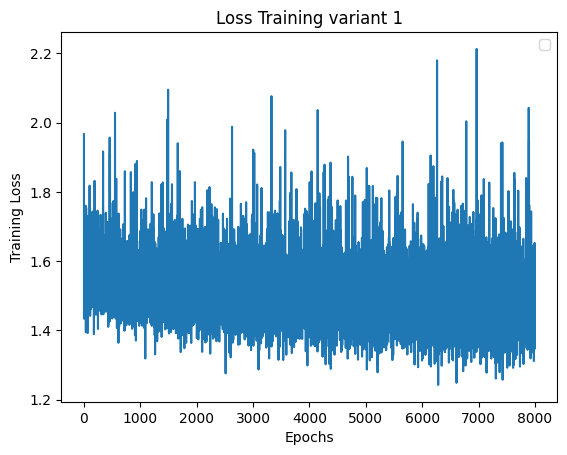

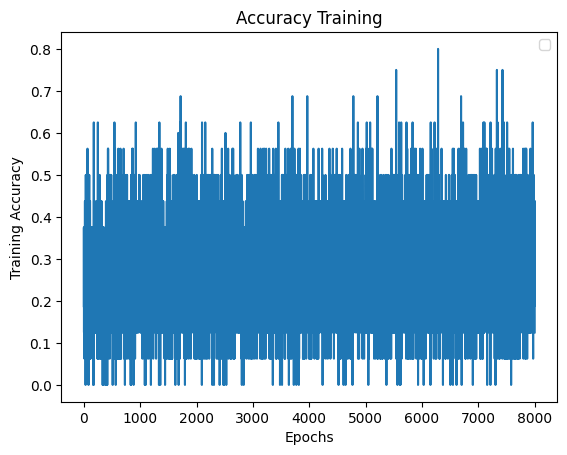

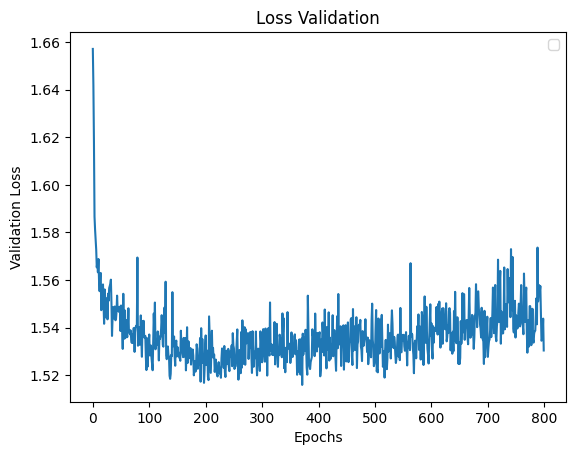

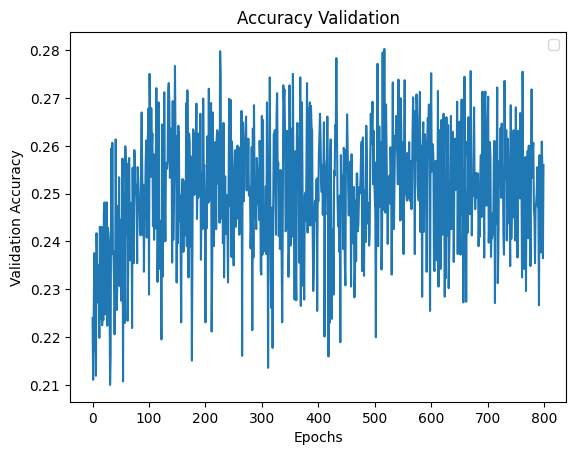

In [ ]:
plotting("variant 1", loss_training, acc_training, loss_val, acc_val)

In [ ]:
net = DeepQBVariant1()
lr = 0.001
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())
loss_training, acc_training, loss_val, acc_val = train(net, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader, 200000, 500, 1000, None, "variant1", t=1, pretrained=False)

LOSS: 1.6011322736740112 ACCURACY: 0.25
LOSS: 1.6139724254608154 ACCURACY: 0.1875
VAL LOSS: 1.5818284057435534 VAL ACCURACY: 0.2494708995024363
LOSS: 1.5462980270385742 ACCURACY: 0.0625
LOSS: 1.720451831817627 ACCURACY: 0.25
VAL LOSS: 1.566571165266491 VAL ACCURACY: 0.2509259259416943
LOSS: 1.4565198421478271 ACCURACY: 0.375
LOSS: 1.6036734580993652 ACCURACY: 0.0625
VAL LOSS: 1.5496380953561693 VAL ACCURACY: 0.2418650794596899
LOSS: 1.356536865234375 ACCURACY: 0.625
LOSS: 1.7304177284240723 ACCURACY: 0.125
VAL LOSS: 1.5465499253500075 VAL ACCURACY: 0.25522486773275194
LOSS: 1.4641002416610718 ACCURACY: 0.375
LOSS: 1.7050572633743286 ACCURACY: 0.1875
VAL LOSS: 1.5519473030453637 VAL ACCURACY: 0.2537698413644518
LOSS: 1.565205693244934 ACCURACY: 0.1875
LOSS: 1.3811216354370117 ACCURACY: 0.4375
VAL LOSS: 1.551521645273481 VAL ACCURACY: 0.24735449737026577
LOSS: 1.5018724203109741 ACCURACY: 0.1875
LOSS: 1.5613813400268555 ACCURACY: 0.3125
VAL LOSS: 1.54835068157741 VAL ACCURACY: 0.26210317

<ipython-input-103-58b221eb660e>:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


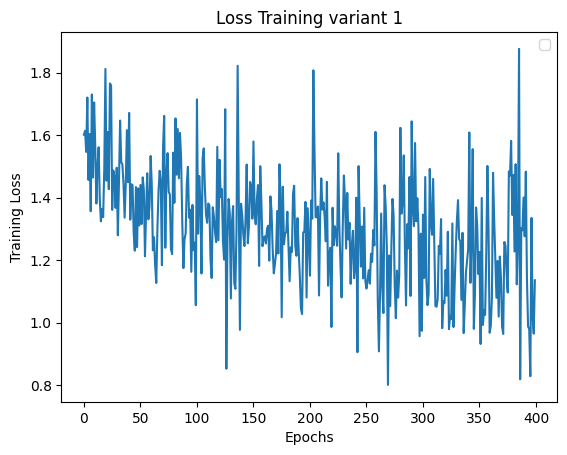

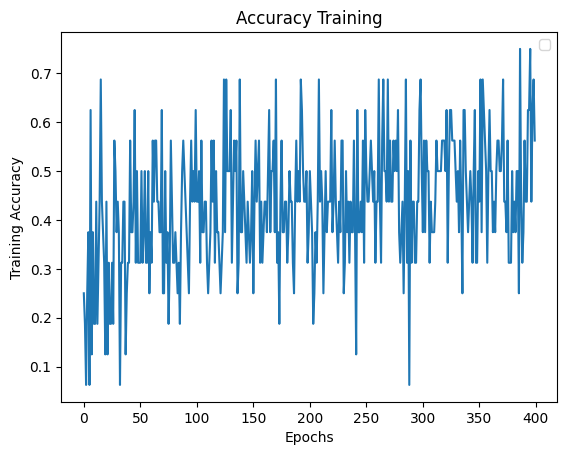

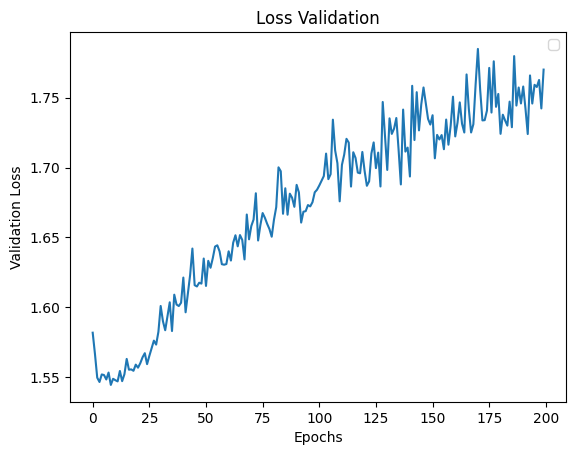

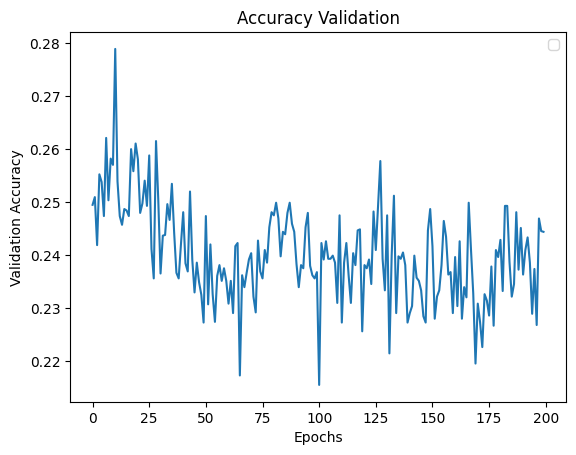

In [ ]:
plotting("variant 1", loss_training, acc_training, loss_val, acc_val)

Testing Variant 1 (without QB orientation)

In [ ]:
train_loader, val_loader = getting_loader(16, save=True, num_workers=0, variant = 1, train_p=0.8, saved=True, drop_qb_orientation=True)

**BEFORE CLEANING** Dataset size: 16123


100%|██████████| 98/98 [00:00<00:00, 4048.32it/s]


**AFTER CLEANING** Dataset size: 8366


In [ ]:
net = DeepQBVariant1(input_dim=116)
lr = 0.001
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())
loss_training, acc_training, loss_val, acc_val = train(net, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader, 200000, 500, 1000, None, "variant1_withoutqborientation", t=1, pretrained=False)

LOSS: 1.5991222858428955 ACCURACY: 0.1875
LOSS: 1.6485042572021484 ACCURACY: 0.3125
VAL LOSS: 1.5635123911358062 VAL ACCURACY: 0.24900793660254705
LOSS: 1.607282280921936 ACCURACY: 0.125
LOSS: 1.5687754154205322 ACCURACY: 0.25
VAL LOSS: 1.5538703566505796 VAL ACCURACY: 0.2586640211797896
LOSS: 1.8000601530075073 ACCURACY: 0.0625
LOSS: 1.5386033058166504 ACCURACY: 0.25
VAL LOSS: 1.5510788372584752 VAL ACCURACY: 0.24404761904761904
LOSS: 1.637718915939331 ACCURACY: 0.1875
LOSS: 1.6783205270767212 ACCURACY: 0.1875
VAL LOSS: 1.5475382918403262 VAL ACCURACY: 0.26177248678037096
LOSS: 1.754488468170166 ACCURACY: 0.25
LOSS: 1.34784996509552 ACCURACY: 0.5
VAL LOSS: 1.5429734774998256 VAL ACCURACY: 0.2521164021321705
LOSS: 1.5078121423721313 ACCURACY: 0.3125
LOSS: 1.426462173461914 ACCURACY: 0.25
VAL LOSS: 1.5458976257415045 VAL ACCURACY: 0.24914021165598008
LOSS: 1.4836013317108154 ACCURACY: 0.4375
LOSS: 1.629384160041809 ACCURACY: 0.1875
VAL LOSS: 1.5513266438529605 VAL ACCURACY: 0.2535052912

<ipython-input-103-58b221eb660e>:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


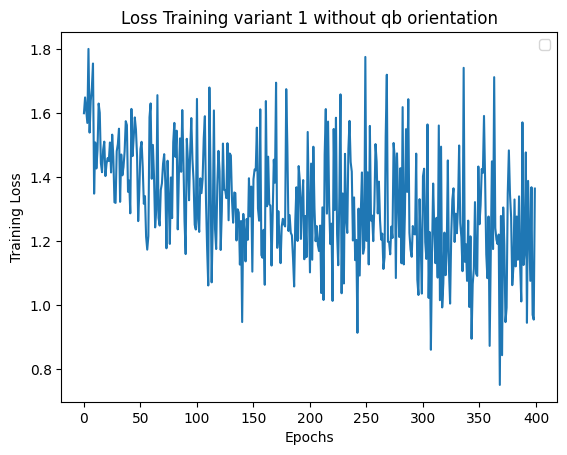

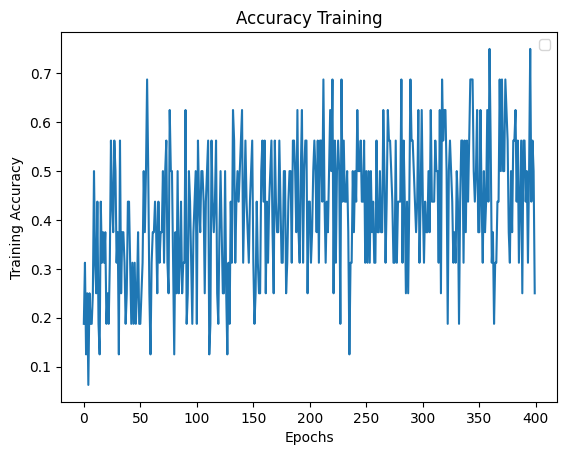

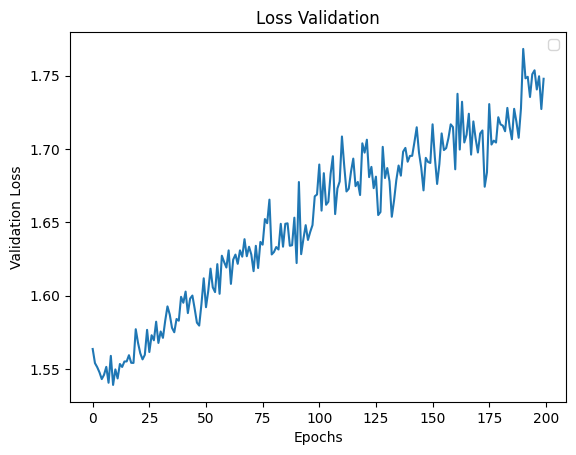

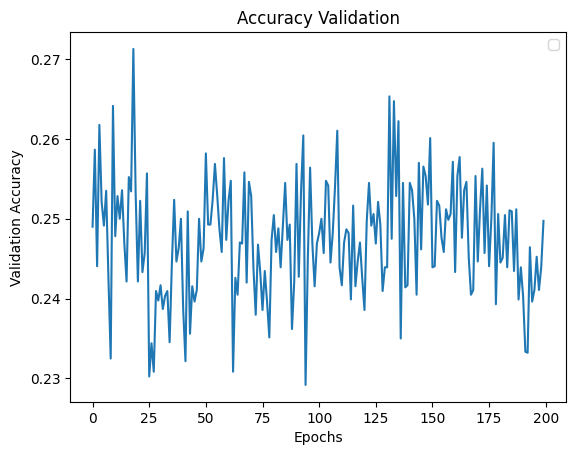

In [ ]:
plotting("variant 1 without qb orientation", loss_training, acc_training, loss_val, acc_val)

dummy test

In [ ]:
dataset = PlaysData(1, pd.read_csv(f"final_data_variant{1}.csv"))

n = len(dataset)

print(f"**BEFORE CLEANING** Dataset size: {n}")
dataset.converting_numerical_and_cleaning()
dataset.get_csv(name = f"./final_data_variant{1}_cleaned.csv")
n_clean = len(dataset)
print(f"**AFTER CLEANING** Dataset size: {n_clean}")

for col in dataset.data.columns:
  if col != "x_0" and col != "result_0.0" and col != "result_1.0" and col != "result_2.0" and col != "result_3.0" and col != "result_4.0":
    dataset.data = dataset.data.drop(col, axis=1)

print(dataset.data)

train_amount = int(n_clean*0.8)
train_indices = list(range(train_amount + 1))
val_indices = list(range(train_amount + 1, n_clean))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=0)


In [ ]:
net = DeepQBVariant1(input_dim=1)
lr = 0.01
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())
loss_training, acc_training, loss_val, acc_val = train(net, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader, 10, 1, 1, None, "variant1_withoutqborientation", t=1, pretrained=False)

Testing Variant 2 (without qb orientation)

In [ ]:
train_loader, val_loader = getting_loader(16, save=True, num_workers=0, variant = 2, train_p=0.8, saved=True, drop_qb_orientation=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/players.csv'

In [ ]:
net = DeepQBVariant1(input_dim=116)
lr = 0.001
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())
loss_training, acc_training, loss_val, acc_val = train(net, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader, 200000, 500, 1000, None, "variant1_withoutqborientation", t=2, pretrained=False)

In [ ]:
plotting("variant 2 without qb orientation", loss_training, acc_training, loss_val, acc_val)

Testing Variant 3 (without qb orientation)

In [ ]:
train_loader, val_loader = getting_loader(16, save=True, num_workers=0, variant = 3, train_p=0.8, saved=True, drop_qb_orientation=True)

In [ ]:
net = DeepQBVariant1(input_dim=116)
lr = 0.001
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())
loss_training, acc_training, loss_val, acc_val = train(net, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader, 200000, 500, 1000, None, "variant1_withoutqborientation", t=3, pretrained=False)

In [ ]:
plotting("variant 3 without qb orientation", loss_training, acc_training, loss_val, acc_val)